In [1]:
from matplotlib import font_manager, rc 
import matplotlib as mpl
font_path = "C:\\Users\\이혜림\\Desktop\\Bita5/malgun.ttf" 
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc("font",family=font_name)
mpl.rcParams["axes.unicode_minus"]=False

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
import os

# 앙상블
- 앙상블 학습 : 일련의 예측기로부터 예측을 수집하여 더 좋은 예측을 얻는 것.
- 일련의 예측기 : 앙상블
- 앙상블 학습 알고리즘 : 앙상블 방법

## 1) 보팅(Voting)

- 각각 다른 분류기를 동일한 데이터셋을 이용하여 학습하여 투표를 통해 예측하는 것
- 직접투표(hard voting) : 각 다른 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것(다수결 투표)
- 간접투표(soft voting) : 각 다른 분류기의 예측확률을 모아서 개별 분류기의 예측확률을 평균 내어 확률이 가장 높은 클래스를 예측하는 것. 보통 직접투표보다 성능이 더 높음

In [7]:
# 보팅 앙상블 모델 생성
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X, y = make_moons(n_samples = 100, noise = 0.15)
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0,
                                                   test_size = 0.3)

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[("lr", log_clf),("rf",rnd_clf),("svc", svm_clf)],
    voting="hard") # soft / hard
# soft voting을 사용할 시 svm의 매개변수 pobability = True 로 바꾸어주어야 함

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                             

In [8]:
# 각 분류기의 테스트셋 정확도 확인
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8333333333333334
RandomForestClassifier 0.9666666666666667
SVC 0.9666666666666667
VotingClassifier 0.9666666666666667


## 2) 배깅

- overfitting이 발생하는 모델에 집중해서 쓰는 것이 좋음 
- 같은 알고리즘을 사용하되, 훈련 세트의 서브셋을 부작위로 구성하여 분류기를 각기 다르게 학습시키는 것
    - 부트스트래핑 : 중복을 허용하여 샘플링하는 방법
    - 페이스팅 : 중복을 허용하지 않고 샘플링하는 방법
    - 부트스트래핑이 페이스팅에 비해 샘플에 다양성을 증가
        - 편향 : 부트스트래핑 > 페이스팅 -> 각각의 모델이 전체 데이터보다 일부 데이터에 맞추어서 학습되기 때문
        - 분산 : 부트스트래핑 < 페이스팅 -> 각각의 모델의 다양성이 증가하면서 보다 일반화가 용이하기 때문
- 앙상블 효과
    - 각기 다른 데이터셋에 대해 overfitting 되기 때문에 전체 앙상블을 했을 때, overfitting이 다 완화되는 효과.
    - 편향은 비슷하고, 분산이 줄어드는 효과
    - overfitting 이 방지되고 보다 일반화된 결과를 얻을 수 있음
- 사이킷런의 Bagging 에서는 디폴트로 직접 투표 방식을 사용 -> predict_proba()를 사용하여 간접투표 형식으로 바꿀 수 있음
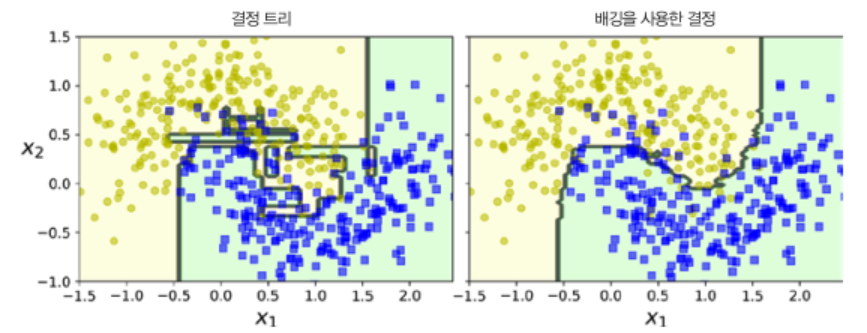

In [14]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=50, bootstrap=True, n_jobs=-1)
# max_samples -> 각각의 분류기에 넣을 샘플의 수, 0~1 사이의 실수값으로 지정하면 전체 데이터셋 수의 %로 들어가게 됨
# n_jobs -> 사용할 cpu의 개수

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

## 2-1) oob 평가
- BaggingClassifier 디폴트 : 부트스트랩, max_samples = m(m개를 선택)
    - 평균적으로 63% 정도만 샘플링됨
- **oob 샘플** : 각 예측기마다 선택되지 않은 훈련 샘플
    - 각 예측기마다 약 37% 정도

In [15]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)

# oob_score = True로 하면 각 분류기의 oob 샘플로 자동으로 각 예측기를 평가하고, 이를 평균내어 반환 가능
# 평균낸 값은 전체 배깅 모델과 비슷한 정확도를 가짐
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9428571428571428

In [17]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9

In [20]:
# oob 샘플에 대한 결정 함수의 값또한 predict_proba와 마찬가지로 각 훈련샘플의 클래스 확률 반환 가능
bag_clf.oob_decision_function_
#bag_clf.predict_proba(X_test)

array([[0.03076923, 0.96923077],
       [0.97777778, 0.02222222],
       [1.        , 0.        ],
       [0.92553191, 0.07446809],
       [1.        , 0.        ],
       [0.02659574, 0.97340426],
       [0.98907104, 0.01092896],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.97311828, 0.02688172],
       [0.        , 1.        ],
       [0.03141361, 0.96858639],
       [0.01363636, 0.98636364],
       [0.02162162, 0.97837838],
       [0.06451613, 0.93548387],
       [0.09836066, 0.90163934],
       [0.11940299, 0.88059701],
       [0.69230769, 0.30769231],
       [0.11666667, 0.88333333],
       [0.        , 1.        ],
       [0.03783784, 0.96216216],
       [0.77297297, 0.22702703],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.97524752, 0.02475248],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.99444444, 0.00555556],
       [0.20809249, 0.79190751],
       [0.

## 2-2) 랜덤 패치와 랜덤 서브스페이스

- 각 모델에 입력할 특성의 개수를 조절하여 각 모델에 들어가는 특성을 다르게 조정할 수도 있음
- max_features / bootstrap_features=True 로 가능
- 무작위로 선택한 특성의 일부분으로 훈련
- overfitting 방지 가능
- 이미지데이터와 같은 고차원 데이터일 때 특히 유용
- 각 예측기의 다양성이 증가 -> overfitting 감소 효과
    - 편향 증가
    - 분산 감소

1. 랜덤 패치 방식 : 훈련 특성과 샘플을 모두 샘플링 하는 것
1. 서브스페이스 방식 : 훈련샘플은 모두 사용(bootstrap=False, max_samples=1.0)하고 특성은 샘플링 하는 것(bootstrap_features=True 또는 max_features < 1.0)

## 2-3) 랜덤 포레스트

- 배깅방식에서 결정트리를 이용하여 학습시키는 것
- max_samples : 전형적으로 m, 부트스트래핑 방법을 사용
- 매개변수
    - 원래 결정트리에서 갖는 매개변수
    - max_features(디폴트값 : 루트 특성수), n_estimators 와 같은 매개변수
        - 특성에 무작위성을 부여함으로써 편향은 좀 더 낮추지만 분산을 감소시킴으로써, 결정트리의 문제점인 overfitting의 문제점을 방지

In [29]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_rf))

0.9666666666666667


In [30]:
# 랜덤포레스트와 거의 같은 모델을 배깅을 통해 만든 방식
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_leaf_nodes=15, max_features="auto"), n_estimators=500,
    max_samples=1.0, bootstrap=True, n_jobs=-1)

bag_clf.fit(X_train, y_train)
y_pred_bc = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_bc))

0.9666666666666667


## 2-3-2) 엑스트라 트리(익스트림 랜덤 트리)


- 익스트림 랜덤 트리 : 최적의 임계값을 찾는 대신 무작위로 분할한 다음 그중에서 최상의 분할을 선택.(나머지는 랜덤포레스트와 완전 동일)
- 좀 더 트리가 무작위하게 만들어지면서 편향은 늘지만, 분산은 줄어드는 효과
- 일반적인 랜덤 포레스트보다 엑스트라 트리가 훨씬 빠름(노드 분할에 가장 많은 시간이 소요되기 때문)
- RandomForestClassifier VS ExtraTreesClassifier
    - 예단하기 힘들기 때문에 둘 다 시도해보는 것이 좋음

## 2-3-3) 특성 중요도

- 특성의 상대적 중요도를 측정하기 쉬움
- Decision Tree의 경우 어떤 feature을 완전히 베재시킨 모델을 만들 수 있지만, RandomForest의 경우 무작위성이 부여되었기 때문에 거의 모든 특성에 대해 평가
- Feature importances = (현재 노드의 샘플 비율 * 불순도) - (왼쪽 자식 노드의 샘플 비율 * 불순도) - (오른쪽 자식 노드의 샘플 비율 * 불순도)

In [38]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
rnd_clf_df = pd.DataFrame(rnd_clf.feature_importances_, index=iris["feature_names"], columns=["importance"])

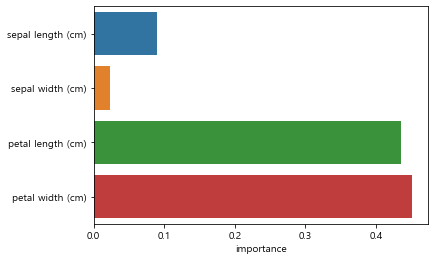

In [39]:
sns.barplot(x="importance", y=rnd_clf_df.index, data=rnd_clf_df)

## 3) 부스팅

- 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법
- 앞의 모델을 보완해나가면서 일련의 예측기를 학습시킴
- AdaBoost, Gradient Boost

## 3-1) Adaboost
#### 개요
- 훈련
    - 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높여서 다음 모델이 과소적합했던 훈련 샘플을 더 잘 분류할 수 있게 하는 것.
    - 결과적으로 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 됨.
- 예측
    - 각 예측기의 정확도에 따라 각 예측기 마다 다른 가중치가 적용, 최종 예측
- 배깅과 같이 병렬화를 통한 학습이 힘들기 때문에 시간이 오래걸림

#### 원리
- 기본적으로 깊이가 1인 결정트리를 사용
- 각 feature을 결정 feature로 하는 결정트리들을 후보로 하여 하나씩 에러율을 계산하여,가장 에러율이 낮은 결정트리를 선택, 다음 모델로 결정

- 에러율 : 각 데이터의 가중치를 적용하여 에러율을 계산
    - 틀리게 예측한 데이터의 가중치의 합 / 전체 데이터의 가중치의 합
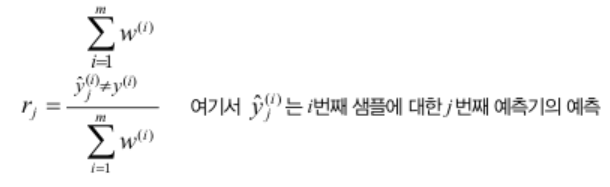

- 각 예측기 가중치
- 가중치를 반영한 데이터를 잘 분류할 수록 각 예측기에 부여되는 가중치의 값이 올라감
- 앞의 값은 learning rate와 같은 용도 : 잘못예측된 데이터에 대해 가중치를 부여할 정도를 정함
    - 디폴트 값은 1
    - 클수록 가중치를 크게 부여함으로써 잘못예측된 데이터를 학습하는 속도가 빨라짐
    - 작을수록 잘못예측된 데이터에 부여하는 가중치가 줄어들기 때문에 데이터를 학습하는 속도가 느림
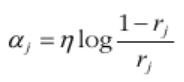

- 가중치 업데이트 규칙
    - 일반적으로 잘 분류하는 모델에서 잘 못 예측한 데이터일 경우 해당 데이터의 가중치를 더 증가시켜줌. 그 후, 모든 데이터의 가중치의 합으로 각각의 가중치를 나눔으로써 정규화 시켜줌
    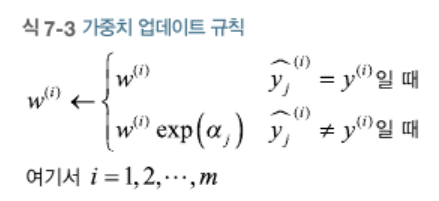

- 훈련 완료
    - 전체 과정이 계속 반복되고, 정해진 예측기 수에 도달하였거나 완벽한 예측기가 만들어지면 훈련이 종료됨

- 예측
    - 단순히 모든 예측기의 예측을 계산하고 예측기 가중치를 곱하여 예측 결과를 만듦
    - 가중치의 합이 가장 큰 클래스가 최종 예측값
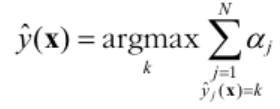

In [59]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm = "SAMME.R", learning_rate = 0.5)

# AdaBoostClassifier의 디폴트 알고리즘 = SAMME.R

ada_clf.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

### 3-1-2) Adaboost 알고리즘
- SAMME
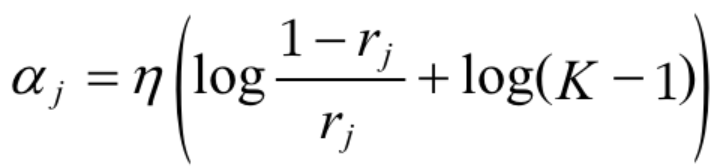
- K : 클래스 수
     - K=2 : 에이다부스트의 알고리즘과 동일
- 클래스 수가 많으면 잘못예측해도 예측기에 그에 대한 패널티를 조금 덜 줌

- SAMME.R
- AdaBoostClassifier의 algorithm 디폴트
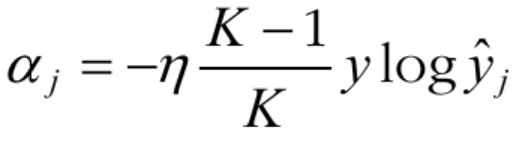
- y : 정답 클래스이면 1, 아니면 -(1/(1-K)).

### 3-1-3) AdaBoostRegressor
    - 깊이가 3인 DecisionTreeRegressor을 기본 추정기로 사용
    - 각 예측기마다 각 데이터의 평균 오차에 대한 가중평균(데이터의 중요도를 기준으로)으로 예측기의 가중치를 정함
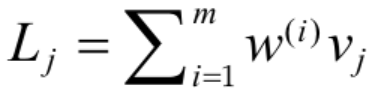

## 3-2) 그레디언트 부스팅
- 이전 예측기가 만든 **잔여 오차**에 새로운 예측기를 학습시킴
- 순서
    1. 첫번째 결정트리 : 데이터에 대해 예측
    1. 두번째 결정트리 : 첫번째 결정트리에서의 예측값과 실제값의 잔차에 대해 학습
    1. 세번째 결정트리 : 실제 잔차였어야 하는 값과 해당 데이터를 두번째 모델에 넣었을 때의 예측 잔차값의 잔차값에 대해 학습
- learning rate는 각 트리의 기여정도를 정함 -> **축소**
    - 많은 트리 개수를 필요로 하지만, 일반적으로 예측성능이 좋아짐
        - learning rate를 1로 해서(트리 개수 적게 가능) 예측하는 것보다 차라리 축소해서 트리 개수를 늘리는 것이 예측 성능이 좋음
        - learning rate를 너무 작게 해서 트리 개수를 너무 많게 하면 overfitting 가능성
    - 만약 타겟 잔차를 토대로 예측한 잔차를 그대로 사용하여 다음 타겟값을 정하면, 바로 실제 y값과 비슷해지기 때문에 예측 잔차에 learning rate를 곱한 값을 타겟 잔차에서 뺀 값을 다음 타겟 잔차로 함.
    - 실제 예측시에 각 트리에서 예측한 잔차를 learning rate로 곱한 후에 더해지기 때문에 각 트리의 기여정도
- 분류문제, 회귀문제 모두 적용 가능
- 결정 트리를 기반 예측기로 사용하는 경우
    - 그레디언트 트리 부스팅
https://dailyheumsi.tistory.com/116

#### 직접 구현

In [63]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [64]:
from sklearn.tree import DecisionTreeRegressor

# 첫번째 학습 트리
tree_reg1 = DecisionTreeRegressor(max_depth = 2)
tree_reg1.fit(X,y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [65]:
# 두번째 학습 트리 -> 첫번째 학습 트리의 잔여 오차에 대해 학습
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth = 2)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [67]:
# 세번째 학습 트리 -> 두번째 학습 트리의 잔여 오차에 대한 학습
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth = 2)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [69]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in [tree_reg1, tree_reg2, tree_reg3])

In [74]:
print(y_pred, 3*(0.8)**(2)+0.05)

[0.75026781] 1.9700000000000004


#### 패키지 사용

In [52]:
# learning rate = 1
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [53]:
# learning rate = 0.1
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

#### 조기중단

In [86]:
# 전체 트리 수로 다 학습을 마친 후 최적의 트리 수 찾기
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X,y)

gbrt = GradientBoostingRegressor(max_depth = 2, n_estimators = 120)
gbrt.fit(X_train, y_train)

# gbrt.pedict(X_val) : 전체 트리를 다 사용하여 예측
# gbrt.staged_predict : 하나부터 점차 쌓아가면서 트리에서 예측을 한 값을 제너레이터로 반환
errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1 # 최적의 트리 개수

gbrt_best = GradientBoostingRegressor(max_depth = 2, n_estimators = bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=63,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Text(0, 0.5, '에러')

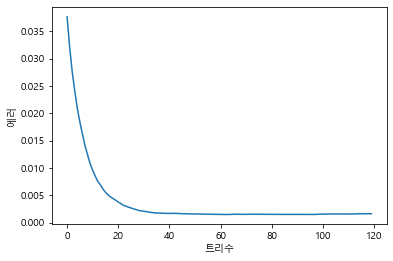

In [93]:
plt.plot(errors)
plt.xlabel("트리수")
plt.ylabel("에러")

In [122]:
# 학습 진행 중에 조기중단
gbrt = GradientBoostingRegressor(max_depth = 2, warm_start=True) # 다음 학습 시 이전 정보를 저장

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1,120):
    gbrt.n_estimators = n_estimators # 반복문이 진행됨에따라 점차 사용하는 트리개수가 많아짐
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1 # 연속해서 검증오치가 향상되지 않은 횟수
        if error_going_up ==5:
            break # 조기종료

### 3-2-1) 확률적 그레디언트 부스팅
- 각 트리가 훈련할 때의 사용할 훈련 샘플의 비율을 지정하고, 각 트리가 무작위로 해당 비율만큼 훈련 샘플을 추출, 학습하는 것
- 편향은 늘어나지만 분산이 줄어듦
- 속도 감소
- subsample : 0~1.0

### 3-2-2) xgboost
- 최적화된 그레디언트 부스팅 구현
- 매우 빠른 속도, 확장성, 이식성

In [124]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

[13:08:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [128]:
# xgboost에서의 조기중단

# 연속 2번 향상되지 않으면 조기중단
xgb_reg.fit(X_train, y_train, eval_set = [(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

[13:10:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.299537
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.269455
[2]	validation_0-rmse:0.243764
[3]	validation_0-rmse:0.219827
[4]	validation_0-rmse:0.198147
[5]	validation_0-rmse:0.180605
[6]	validation_0-rmse:0.165174
[7]	validation_0-rmse:0.151137
[8]	validation_0-rmse:0.13711
[9]	validation_0-rmse:0.125448
[10]	validation_0-rmse:0.115371
[11]	validation_0-rmse:0.10625
[12]	validation_0-rmse:0.097635
[13]	validation_0-rmse:0.090476
[14]	validation_0-rmse:0.08406
[15]	validation_0-rmse:0.078254
[16]	validation_0-rmse:0.072409
[17]	validation_0-rmse:0.067961
[18]	validation_0-rmse:0.063653
[19]	validation_0-rmse:0.059806
[20]	validation_0-rmse:0.057162
[21]	validation_0-rmse:0.054394
[22]	validation_0-rmse:0.0519
[23]	validation_0-rmse:0.050006
[24]	validation_0-rmse:0.04857
[25]	validation_0-rmse:0.047513
[26]

## 4) 스태킹
- 앙상블에 속한 모든 예측기의 예측을 단순 취합하는 대신 취합하는 모델을 사용하여 최종 예측
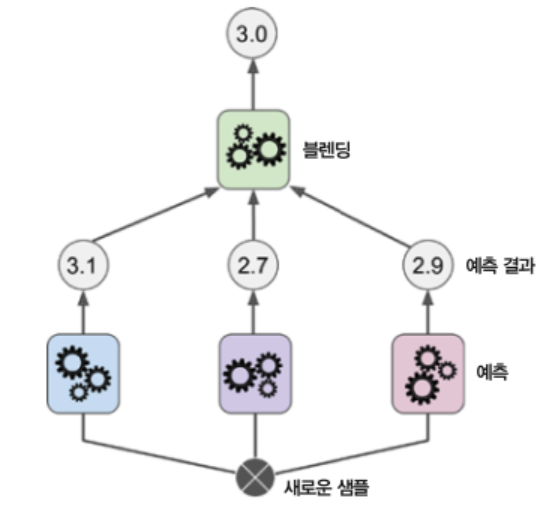

- 일반적으로 홀드 아웃 세트를 사용
    - 아웃 오브 폴드 : k-겹 교차 검증에서의 검증 폴드의 결과를 모두 모은 것
    - 홀드 아웃 세트 : k-겹 교차 검증에서 각각의 홀드
- 순서
    - 데이터셋을 레이어의 개수로 나눔(일단 2개라고 가정-> 2개의 서브셋으로 나눔)
    - 첫번째 레이어에서 각 모델을 첫번째 서브셋으로 훈련(첫번째 레이어의 개수 : 3개라고 가정)
    - 두번째 서브셋을 훈련된 첫번재 레이어의 각 모델으로 예측
    - 두번째 레이어(여기선 블렌더)에 각 모델의 예측값을 feature로 하는 3차원 데이터셋을 훈련

- 두개의 레이어
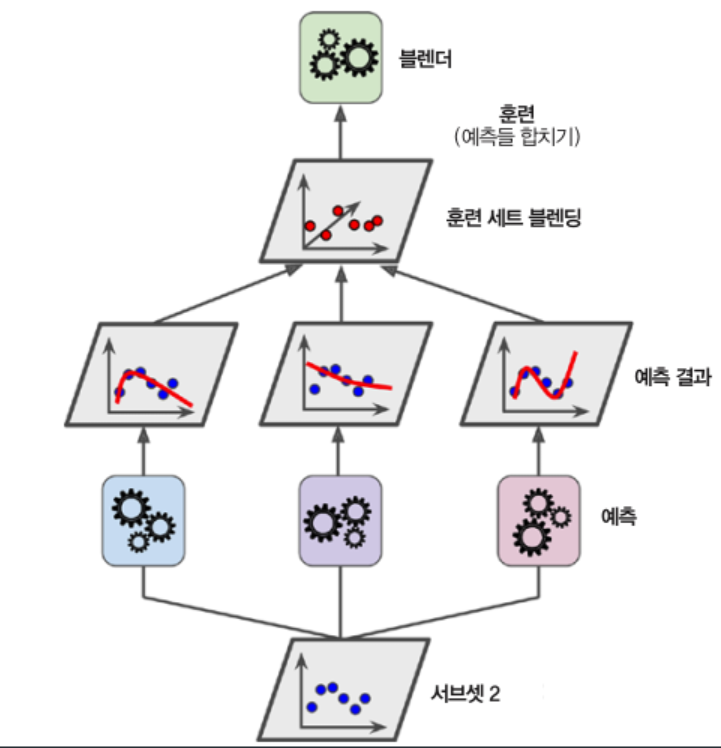

- 3개의 레이어
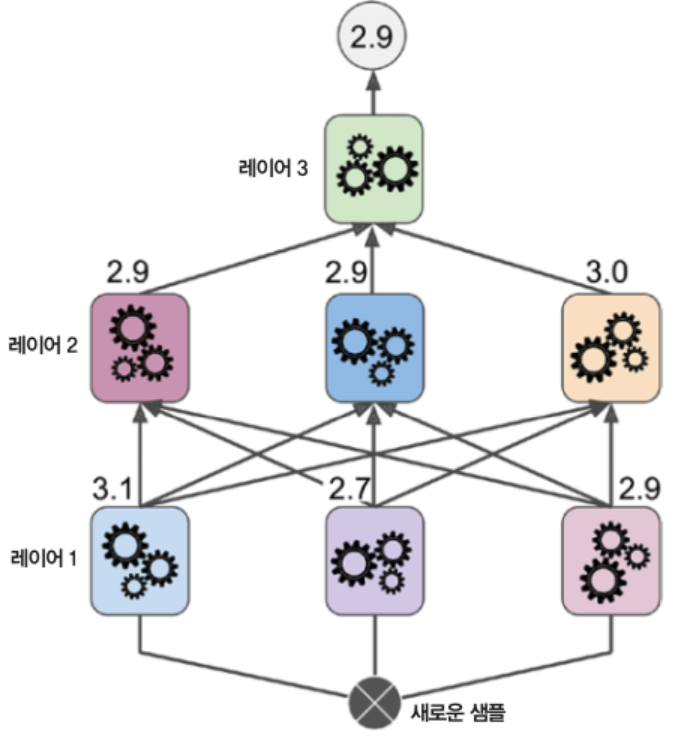